## Imports

In [1]:
import pandas as pd
import ast,re,graphviz,json
from fractions import Fraction
from IPython.display import Image,display,clear_output
from sentence_transformers import SentenceTransformer
import numpy as np
import pickle
from pyspark.sql import SparkSession,Row
from pyspark.sql.functions import from_json,col,concat_ws,coalesce,lower,udf,explode
from pyspark.sql.types import ArrayType,StringType,MapType,BooleanType

try :
    spark.stop
except:
    pass
    
spark = SparkSession.builder \
    .appName("RecipeApp") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/13 16:18:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the datasets

In [2]:
#Spark
spark_recipes = spark.read.csv(
    "datasets/recipes.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"',       # handle embedded quotes
    quote='"'         # treat quotes properly
)

spark_nutri = spark.read.csv('datasets/opennutrition/opennutrition_foods.tsv',sep='\t',header=True,inferSchema=False)
spark_recipes.select("tags", "search_terms", "ingredients").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tags                                                                                         

25/12/13 16:18:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
 Schema: _c0, id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
Expected: _c0 but found: 
CSV file: file:///Users/anujk123/Desktop/MWC/Project/RecipePicker/datasets/recipes.csv


# Dataset Structure

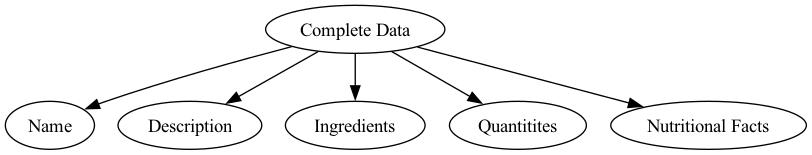

In [3]:

dot = graphviz.Digraph('Dataset', comment='The structure of dataset')  
dot.node('A','Complete Data')
dot.node('B','Name')
dot.node('C','Description')
dot.node('D','Ingredients')
dot.node('E','Quantitites')
dot.node('F','Nutritional Facts')
dot.edges(['AB','AC','AD','AE','AF'])
dot.render(filename='data',format='png')
display(Image('data.png'))

# Manipulating Data

### Helper Functions

In [3]:
#Convert the ingredients stored as a single string to list of strings i.e. list of individual ingredients


UNITS = {
        "kg","g","lb","lbs","pound","pounds","cup","cups","teaspoon","teaspoons","tsp",
        "tablespoon","tablespoons","tbsp","clove","cloves","quart","quarts",
        "liter","liters","oz","ounce","ounces"
    }
    
DESCRIPTORS = {
    "small","large","medium","extra","fresh","dried","minced","crushed","chopped","sliced","diced",
    "canned","meat"
}



def clean_ingredient_name(name):
    # lowercase
    name = name.lower().strip()

    # remove within bracket text
    name = re.sub(r"\([^)]*\)", "", name).strip()
    # remove commas
    name = re.sub(r",", " ", name)

    #remove brands
    name = re.split(r"\s+by\s+", name, flags=re.IGNORECASE)[0]

    # collapse multiple spaces
    name = re.sub(r"\s+", " ", name)

    # remove descriptors
    tokens = [
        t for t in name.split()
        if t not in DESCRIPTORS
    ]

    if not tokens:
        return name

    name = " ".join(tokens)

    # singularize simple plurals (basic heuristic)
    if name.endswith("es") and name[:-2] in ["tomato", "potato"]:
        name = name[:-2]
    

    return name

def parse_fraction(s):
    """Convert strings like '1', '1/2', '1 1/2', '1-2', '1 1/2-2 1/2' into float."""
    if not s:
        return None
    s = s.strip()
    
    # --- RANGE HANDLING ---
    if '-' in s:
        parts = s.split('-')
        # handle ranges with mixed fractions
        numbers = [parse_fraction(p) for p in parts if p.strip()]
        if numbers:
            return sum(numbers)/len(numbers)
        return None
    
    # --- MIXED FRACTION (e.g. "1 1/2") ---
    parts = s.split()
    if len(parts) == 2:
        return float(Fraction(parts[0]) + Fraction(parts[1]))
    
    # --- SIMPLE NUMBER OR SIMPLE FRACTION ---
    return float(Fraction(parts[0]))


def parse_ingredient(line):
    
    if not line or line.strip() == "":
        return None
    
    line = line.strip()
    
    # First try parentheses / container style
    paren_match = re.match(r"(\d+(?: \d+/\d+)?|\d+/\d+)\s*\(([^)]+)\)\s*(\w+)?\s*(.*)", line)
    if paren_match:
        qty_str, paren_unit, container_unit, rest = paren_match.groups()
        quantity = parse_fraction(qty_str)
        unit = None
        ingredient = clean_ingredient_name(rest)
        for u in UNITS:
            if u in paren_unit.lower():
                unit = u
                break
        if not unit and container_unit:
            unit = container_unit.lower()
        return {ingredient: {"quantity": quantity, "unit": unit}}
    
    # Normal parsing
    qty_match = re.match(r"^(\d+\s\d+/\d+|\d+/\d+|\d+(?:-\d+)?)", line)
    quantity = None
    rest = line
    if qty_match:
        quantity_str = qty_match.group(1)
        quantity = parse_fraction(quantity_str)
        rest = line[len(quantity_str):].strip()

    unit = None
    parts = rest.split()
    if parts and parts[0].lower() in UNITS:
        unit = parts[0].lower()
        rest = " ".join(parts[1:])
    
    ingredient = clean_ingredient_name(rest)
    return {ingredient: {"quantity": quantity, "unit": unit}}








In [4]:
from pyspark.sql import functions as F

def singularize(col):
    return (
        F.when(col.rlike("ies$"), F.regexp_replace(col, "ies$", "y"))     # berries → berry
         .when(col.rlike("oes$"), F.regexp_replace(col, "oes$", "o"))     # tomatoes → tomato
         .when(col.rlike("ses$"), F.regexp_replace(col, "es$", ""))       # classes → class
         .when(
             col.rlike("s$") & ~col.rlike("ss$"),                         # onions → onion, but not glass
             F.regexp_replace(col, "s$", "")
         )
         .otherwise(col)
    )


### Preprocess Data

In [5]:
#Spark
from pyspark.sql.functions import transform,col,regexp_replace,split
spark_recipes = spark_recipes.withColumn(
    "ingredients",
    from_json(col("ingredients"), ArrayType(StringType()))
).withColumn(
    "tags",
    from_json(col("tags"), ArrayType(StringType()))
).withColumn(
    "search_terms",
    regexp_replace(col("search_terms"), r"[{}']", "")
).withColumn(
    "search_terms",
    split(col("search_terms"), ",\s*")
)
STOPWORDS = ['fresh','by','salted','ground','shredded','w','sea']


spark_nutri = spark_nutri.withColumn("name", lower(col("name")))
# Define a UDF
clean_ingredient_udf = udf(clean_ingredient_name, StringType())

# Apply the UDF to 'name'
spark_nutri = spark_nutri.withColumn("name", clean_ingredient_udf(col("name")))
spark_nutri = spark_nutri.withColumn(
    "name",
    singularize(F.lower(F.col("name")))
)
spark_recipes = spark_recipes.withColumn(
    "ingredients",
    transform(col('ingredients'), lambda x : singularize(lower(x)))
)
spark_recipes = spark_recipes.withColumn(
    "ingredients_raw_str",
    singularize(F.lower(F.col("ingredients_raw_str")))
)



<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/fg/rcm5vs591wq28dcr6q80hr0m0000gn/T/ipykernel_63570/1821750663.py:14: SyntaxWarning: invalid escape sequence '\s'
  split(col("search_terms"), ",\s*")


In [ ]:
spark_recipes.select("search_terms").show(truncate=False)

### Matching ingredients in nutrition data and recipes

In [6]:
# Spark Version
import json
rows = spark_nutri.select("name", "nutrition_100g", "serving", "alternate_names").collect()

nutrition_lookup = {row['name']: json.loads(row['nutrition_100g']) for row in rows}
quant_lookup = {row['name']: json.loads(row['serving']) for row in rows}

alias_name_map = {}
for row in rows:
    org = row['name']
    alias_name_map[org] = org
    aliases = json.loads(row['alternate_names'])
    for alias in aliases:
        alias_name_map[alias] = org

from pyspark.sql import functions as F

alias_name_map_bc   = spark.sparkContext.broadcast(alias_name_map)
nutrition_lookup_bc = spark.sparkContext.broadcast(nutrition_lookup)
quant_lookup_bc     = spark.sparkContext.broadcast(quant_lookup)



### ML Pipeline for better matching with the help of description in nutrition data

### Spark Version

### Stop Word Removal and Lemmatization

In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_names_for_embeddings(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = [lemmatizer.lemmatize(t) for t in text.split() if t not in stop_words]
    return " ".join(tokens)


In [8]:
def unique_text_spark(name, alternate_names):
    tokens = []
    seen = set()
    for p in [name, alternate_names]:
        if isinstance(p, list):
            p = " ".join(map(str, p))
        else:
            p = str(p)
        p = preprocess_names_for_embeddings(p)
        for t in p.split():
            if t.lower() not in seen:
                seen.add(t.lower())
                tokens.append(t)
    return " ".join(tokens)

unique_text_udf = udf(unique_text_spark, StringType())

spark_nutri = spark_nutri.withColumn(
    "nutrition_text",
    unique_text_udf(col("name"), col("alternate_names"))
)

# Explode ingredients into separate rows
all_recipe_ingredients = spark_recipes.select(explode(col("ingredients")).alias("ingredient"))

# Remove empty strings / whitespace
all_recipe_ingredients = all_recipe_ingredients.filter(col("ingredient").isNotNull() & (col("ingredient") != ""))

# Remove duplicates
all_recipe_ingredient = all_recipe_ingredients.dropDuplicates(["ingredient"])

# Collect nutrition_text column as Python list
nutrition_texts = [row['nutrition_text'] for row in spark_nutri.select("nutrition_text").collect()]

nutrition_names = [row['name'] for row in spark_nutri.select("name").collect()]

all_recipe_ingredients = [row['ingredient'] for row in all_recipe_ingredients.collect()]






25/12/13 16:19:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
 Schema: _c0, id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
Expected: _c0 but found: 
CSV file: file:///Users/anujk123/Desktop/MWC/Project/RecipePicker/datasets/recipes.csv


In [19]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

#nutrition_embeddings = model.encode(nutrition_texts, normalize_embeddings=True, batch_size=64)
recipe_ingr_embeddings = model.encode(all_recipe_ingredients, normalize_embeddings=True, batch_size=64)

recipe_embeddings = {ingr: emb for ingr, emb in zip(all_recipe_ingredients, recipe_ingr_embeddings)}

nutrition_embeddings = model.encode(nutrition_texts,normalize_embeddings=True,batch_size=64)

### Save embeddings for faster execution

In [20]:
with open("ingredient_embeddings.pkl", "wb") as f:
    pickle.dump(recipe_embeddings, f)

with open("nutrition_embeddings.pkl", "wb") as f:
    pickle.dump(nutrition_embeddings, f)


### Free memory by deleting Transformer

In [10]:

import gc
if model : 
    del model
gc.collect()  


import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


NameError: name 'model' is not defined

### Load the embeddings

In [9]:


with open("ingredient_embeddings.pkl", "rb") as f:
    recipe_emb = pickle.load(f)

with open("nutrition_embeddings.pkl", "rb") as f:
    nutri_emb = pickle.load(f)

broadcast_nutri_emb = spark.sparkContext.broadcast(nutri_emb)
broadcast_recipe_emb = spark.sparkContext.broadcast(recipe_emb)
broadcast_nutrition_names = spark.sparkContext.broadcast(nutrition_names)



### Function to use the embeddings for semantic matching

In [10]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def semantic_match_spark(ingredient, threshold=0.4):
    vec = broadcast_recipe_emb.value.get(ingredient)
    if vec is None:
        return 'Not Found'
    sims = np.dot(broadcast_nutri_emb.value, vec)
    best_idx = sims.argmax()
    best_score = sims[best_idx]
    if best_score < threshold:
        return None
    return broadcast_nutrition_names.value[best_idx]

semantic_match_udf = udf(semantic_match_spark, StringType())

semantic_match_spark('veal sausage')



'sweet italian veal sausage'

In [11]:
import json
def match_ingredients(recipe_clean_list, flag=0, threshold=85):
    """
    Matches ingredients. flag=0 -> nutrition, flag=1 -> quantity metrics.
    Returns: matched_dict, list_of_unmatched_ingredient_names
    """
    matched = {}
    unmatched = []
    alias_name_map = alias_name_map_bc.value
    nutrition_lookup = nutrition_lookup_bc.value
    quant_lookup = quant_lookup_bc.value

    for r in recipe_clean_list:
        mapped_name = alias_name_map.get(r, r)
        try:
            if flag == 0:
                # nutrient match
                matched[mapped_name] = nutrition_lookup.get(mapped_name, None)
                
            else:
                # quantity match
                metric = quant_lookup.get(mapped_name, {}).get('metric', {'quantity': 0, 'unit': 'g'})
                matched[mapped_name] = metric
        except Exception:
            unmatched.append(r)
            continue

        if mapped_name not in matched or matched[mapped_name] is None:
            unmatched.append(r)
            matched.pop(mapped_name, None)

    return matched, unmatched

x = match_ingredients(['red bell pepper'])
print(x[0]['red bell pepper']['calories'])
alias_name_map_bc.value['bell pepper red']


31


'red bell pepper'

### Spark

In [72]:
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

nutrition_schema = StructType([
    StructField("calories", DoubleType(), True),
    StructField("total_fat", DoubleType(), True),
    StructField("total_sugars", DoubleType(), True),
    StructField("dietary_fiber", DoubleType(), True),
    StructField("matched_name", StringType(), True)
])

@udf(nutrition_schema)
def match_ingredient_udf(ingredient):
    if ingredient is None:
        return None

    alias_map = alias_name_map_bc.value
    nutrition_map = nutrition_lookup_bc.value

    # Exact / alias match
    if ingredient in alias_map:
        key = alias_map[ingredient]
        n = nutrition_map.get(key)
        if n:
            return (*[n.get(k) for k in ['calories','total_fat','total_sugars','dietary_fiber']], key)

    # Semantic fallback
    match = semantic_match_spark(ingredient)
    if match and match != "Not Found":
        n = nutrition_map.get(match)
        if n:
            return (*[n.get(k) for k in ['calories','total_fat','total_sugars','dietary_fiber']], match)

    return None


### Matching pantry with recipes

#### Filtering recipes that are not meals

### Spark

In [12]:



def is_meal_row_udf(tags, search_terms, ingredients):
    NON_MEAL_TAGS = {
        "dips", "sauces", "chutneys", "condiments-etc",
        "appetizers", "snacks", "breads", "muffins", 
        "cookies-and-brownies", "desserts",'cocktail',
        'dressing','juice','canning','salad-dressings',
        'appetizers','appetizer','garnishes','snack',
        'snacks','side-dishes','side-dish','side',
        'dessert','drink','dips-lunch-snacks','freezer-desserts',
        'appetizers-seafood','puddings-and-mousses','dips-summer',
        'garnishes','candy','onions-side-dishes','gluten-free-appetizers',
        'no-bake-cookies','cookies-and-brownies','brownies','cookies-and-brownies-nuts',
        'shakes', 'lime-desserts','beverages','cocktails',   
    }
    
    BASIC_INGREDIENTS = {
        "salt","water","butter","olive oil","oil",
        "vinegar","pepper","honey","milk",'flour'
    }
    if not ingredients or any(not ing or not ing.strip() for ing in ingredients):
        return False

    combined_tags = set(tags or []) | set(search_terms or [])

    if not combined_tags:
        return False

    if combined_tags & NON_MEAL_TAGS:
        return False

    if len(ingredients) <= 3:
        return False

    if all(ing.lower() in BASIC_INGREDIENTS for ing in ingredients):
        return False

    return True

is_meal_udf_spark = udf(is_meal_row_udf, BooleanType())

spark_recipes = spark_recipes.withColumn(
    "is_meal",
    is_meal_udf_spark("tags", "search_terms", "ingredients")
)
spark_recipes.filter(col("is_meal") == True).count()


25/12/13 16:20:34 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
 Schema: _c0, id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
Expected: _c0 but found: 
CSV file: file:///Users/anujk123/Desktop/MWC/Project/RecipePicker/datasets/recipes.csv


218480

### User Information

In [13]:
pantry = {"salt" : 1, "olive oil" : 1000, "rice" : 5,'onion' : 5,'bread' : 5, "garlic" : 1,'tomatoes' : 5,'beef' : 2,'potato' : 3,'eggs' : 12,'chicken' : 3}
gender = 'm'
age = 27
weight = 73
height = 179
BMR = 0 
if gender == 'm' :
    BMR = 88.362 + 13.397 * weight + 4.799 * height - 5.677 * age
else :
    BMR = 447.593 + 9.247 * weight + 3.098 * height - 4.330 * age

activity_level = [1.2,1.375,1.55,1.725,1.9]
req_calories = BMR * activity_level[0]

req_sugar = 0.09 * req_calories
req_fat = 0.29 * req_calories
req_salt = 5
req_fruit_veg = 400

'''
units = set()
for index,entry in df_nutri.iterrows():
    #print(entry['serving'])
    unit = entry['serving']['common']['unit']
    if unit in UNITS :
        #print(entry['nutrition_100g'])
        units.add(unit)


units = sorted(units)
print(units)'''



"\nunits = set()\nfor index,entry in df_nutri.iterrows():\n    #print(entry['serving'])\n    unit = entry['serving']['common']['unit']\n    if unit in UNITS :\n        #print(entry['nutrition_100g'])\n        units.add(unit)\n\n\nunits = sorted(units)\nprint(units)"

### Recommended Recipes

In [14]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, ArrayType, StringType

# Assume pantry is a Python dict, e.g., pantry = {"rice": 1, "salt": 2, ...}
pantry_set = set(pantry.keys())

# UDF to compute missing ingredients
def missing_ingredients_udf(ingredients):
    if not ingredients:
        return [], 0
    recipe_set = set(ingredients)
    missing = list(recipe_set - pantry_set)
    return missing, len(missing)

# Separate UDFs for missing list and missing count
def missing_list(ingredients):
    if not ingredients:
        return []
    return list(set(ingredients) - pantry_set)

def missing_count(ingredients):
    if not ingredients:
        return 0
    return len(set(ingredients) - pantry_set)

# Register UDFs
missing_list_udf = udf(missing_list, ArrayType(StringType()))
missing_count_udf = udf(missing_count, IntegerType())

# Apply to Spark DataFrame
spark_recipes = spark_recipes.withColumn("missing", missing_list_udf(col("ingredients")))
spark_recipes = spark_recipes.withColumn("missing_count", missing_count_udf(col("ingredients")))

# The final recommendations DataFrame
recommendations_spark = spark_recipes.select(
    col("id").alias("recipe_id"),
    col("missing_count"),
    col("missing")
)
print(recommendations_spark)


DataFrame[recipe_id: int, missing_count: int, missing: array<string>]


In [15]:
from pyspark.sql.functions import col

# Filter valid meals
valid_recs = recommendations_spark.join(
    spark_recipes.select("id", "name", "is_meal"),
    recommendations_spark.recipe_id == spark_recipes.id,
    "inner"
).filter(
    (col("name") != "") & (col("is_meal") == True)
)

# Sort by missing_count and take top 5
top_recipes = valid_recs.orderBy(col("missing_count").asc()).limit(5)

# Collect results to driver to print
top_recipes_list = top_recipes.collect()
for recipe in top_recipes_list:
    print(recipe)


25/12/13 16:20:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
 Schema: _c0, id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
Expected: _c0 but found: 
CSV file: file:///Users/anujk123/Desktop/MWC/Project/RecipePicker/datasets/recipes.csv
25/12/13 16:20:53 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
 Schema: _c0, id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
Expected: _c0 but found: 
CSV file: file:///Users/anujk123/Desktop/MWC/Project/RecipePicker/datasets/recipes.csv


Row(recipe_id=49305, missing_count=1, missing=['pork hock'], id=49305, name="Spike's Jellied Pork Hocks", is_meal=True)
Row(recipe_id=68095, missing_count=1, missing=['kielbasa'], id=68095, name='Kielbasa and Potatoes', is_meal=True)
Row(recipe_id=11476, missing_count=1, missing=['asparagu'], id=11476, name='Oven Roasted Asparagus With Garlic', is_meal=True)
Row(recipe_id=132705, missing_count=1, missing=['egg'], id=132705, name='Spanish Potato Tortilla', is_meal=True)
Row(recipe_id=394823, missing_count=1, missing=['green bean'], id=394823, name='Homemade Beef Meal for Dogs', is_meal=True)


### Nutrition extraction

In [16]:
UNIT_CONVERSION_TO_GRAMS = {
    "g": 1,
    "kg": 1000,
    "lb": 453.592,
    "lbs": 453.592,
    "pound": 453.592,
    "pounds": 453.592,
    "oz": 28.3495,
    "ounce": 28.3495,
    "ounces": 28.3495,
    "cup": 240,
    "cups": 240,
    "tablespoon": 15,
    "tablespoons": 15,
    "tbsp": 15,
    "teaspoon": 5,
    "teaspoons": 5,
    "tsp": 5,
}

def to_grams(name, quantity, unit):
    name = name.lower()

    
    if unit in ("g", "gram", "grams"):
        return quantity
    
    if unit in ("kg",):
        return quantity * 1000

    if unit in ("lb", "lbs", "pound", "pounds"):
        return quantity * 453.592

    if unit in ("oz", "ounce", "ounces"):
        return quantity * 28.3495

    
    if unit in ("cup", "cups"):
        return  240 * quantity
    elif unit in ("tablespoon", "tablespoons", "tbsp"):
        return 15 * quantity
    elif unit in ("teaspoon", "teaspoons", "tsp"):
        return 5 * quantity
   

    return None  




def calc_nutrients(quants):
    final_nutri = {'total_sugars': 0, 'dietary_fiber': 0, 'total_fat': 0, 'calories': 0}
    not_calced = {'total_sugars': [], 'dietary_fiber': [], 'total_fat': [], 'calories': []}
    nutrients = {
        'calories','total_fat','total_sugars','dietary_fiber'
    }
    for ingr, quant_info in quants.items():
        match, unmatch = match_ingredients([ingr])

        if unmatch:
            for nutrient in nutrients:
                not_calced[nutrient].append(ingr)
        else:
            nutrition = list(match.values())[0]
            for nutrient in nutrients:
                if quant_info['weight'] and nutrient in nutrition.keys():
                    final_nutri[nutrient] += nutrition[nutrient] * quant_info['weight'] / 100
                else:
                    not_calced[nutrient].append(ingr)

    return final_nutri, not_calced




def convert_quants(quan):
    '''
    Convert the quants to universal metric unit for easier nutrition calculation
    '''
    converted_quan = {}
    for ingr,inf in quan.items():
        if not inf['unit'] and not inf['quantity'] :
            converted_quan[ingr] = {'unit' : 'g', 'weight' : 0}
        else : 
            if inf['quantity']:
                weight = to_grams(ingr,inf['quantity'],inf['unit']) if inf['unit']!= None else 0
            else :
                weight = 0
            if not weight and inf['quantity'] :
                matched,unmatched = match_ingredients([ingr],flag=1)
                #print(matched,unmatched)
                if unmatched :
                    weight = 0
                if matched : 
                    #print(matched)
                    matched = list(matched.values())[0]
                    weight = to_grams(ingr,inf['quantity'] * matched['quantity'],matched['unit'])
                else :
                    weight = 0
                    
            converted_quan[ingr] = {'unit' : 'g' , 'weight' :weight}


    return converted_quan

def extract_quants(raw_ingrs,ingrs):
    '''
    Extracts the quantities of the ingrediets for recommended recipes 
    '''
    parsed = {}
    raw_ingrs = json.loads(raw_ingrs) if isinstance(raw_ingrs,str) else raw_ingrs
    for raw, name in zip(raw_ingrs, ingrs):
        ing = parse_ingredient(raw)
        if ing:
            key = clean_ingredient_name(name)
            parsed[key] = list(ing.values())[0]
    return parsed





### Spark

### Quant Schema

In [17]:
from pyspark.sql.types import StructType,StructField,DoubleType
quant_schema = MapType(
    StringType(),
    StructType([
        StructField("quantity", DoubleType(),True),
        StructField("unit", StringType(),True)
    ])
)

@udf(returnType=quant_schema)
def extract_quants_udf(raw_ingrs, ingrs):
    extracted = extract_quants(raw_ingrs,ingrs)
    return { ingr: Row(quantity = info['quantity'],unit = info['unit']) for ingr,info in extracted.items()}

@udf(returnType=MapType(StringType(), StructType([StructField("weight", DoubleType(),True),StructField("unit", StringType(),True)])))
def convert_quants_udf(quants):
    converted = convert_quants(quants)
    return { ingr: Row( weight = info['weight'], unit = info['unit']) for ingr,info in converted.items()}

nutri_schema = StructType([
    StructField("calories", DoubleType()),
    StructField("total_fat", DoubleType()),
    StructField("total_sugars", DoubleType()),
    StructField("dietary_fiber", DoubleType())
])

missing_schema = MapType(StringType(), ArrayType(StringType()))

@udf(returnType=StructType([
    StructField("nutrients", nutri_schema),
    StructField("missing", missing_schema)
]))
def calc_nutrients_udf(quants):
    nutri, missing = calc_nutrients(quants)
    return {"nutrients": nutri, "missing": missing}

# -----------------------
# PHASE 3: Apply to Spark DataFrame
# -----------------------

spark_meals = spark_recipes.filter(col("is_meal") == True)

spark_meals = spark_meals.withColumn(
    "quants",
    extract_quants_udf(col("ingredients_raw_str"), col("ingredients"))
).withColumn(
    "quants_g",
    convert_quants_udf(col("quants"))
).withColumn(
    "nutri_struct",
    calc_nutrients_udf(col("quants_g"))
)

# Extract final columns
spark_meals = spark_meals \
    .withColumn("nutrients", col("nutri_struct.nutrients")) \
    .withColumn("missing_nutrients", col("nutri_struct.missing"))


### Execution

In [18]:
from pyspark.sql.functions import to_json

spark_meals_flat = spark_meals.select(
    "id",
    "name",
    "serving_size",
    "steps",
    to_json("quants_g").alias("quants_g"),
    to_json("missing_nutrients").alias("missing_nutrients"),
    col("nutrients.calories").alias("calories"),
    col("nutrients.total_fat").alias("total_fat"),
    col("nutrients.total_sugars").alias("total_sugars"),
    col("nutrients.dietary_fiber").alias("dietary_fiber")
)

spark_meals_flat.write.mode("overwrite").csv("datasets/final_data", header=True)


25/12/13 16:21:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
 Schema: _c0, id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
Expected: _c0 but found: 
CSV file: file:///Users/anujk123/Desktop/MWC/Project/RecipePicker/datasets/recipes.csv


### Semantic Match Run

In [19]:
from pyspark.sql.functions import map_values, flatten, array_distinct

spark_meals = spark_meals.withColumn(
    "missing_ingredients",
    array_distinct(
        flatten(map_values(col("missing_nutrients")))
    )
)


In [20]:
def semantic_match_ingredients(ingredients, threshold=0.4):
    matched = {}
    unmatched = []

    for ingr in ingredients:
        vec = broadcast_recipe_emb.value.get(ingr)

        if vec is None:
            unmatched.append(ingr)
            continue

        sims = np.dot(broadcast_nutri_emb.value, vec)
        best_idx = int(sims.argmax())
        best_score = sims[best_idx]

        if best_score < threshold:
            unmatched.append(ingr)
            continue

        canon = broadcast_nutrition_names.value[best_idx]
        matched[ingr] = nutrition_lookup_bc.value[canon]

    return matched, unmatched


In [21]:
def calc_semantic_nutrients(quants, missing, use_semantic=True):
    recovered = {'total_sugars': 0, 'dietary_fiber': 0, 'total_fat': 0, 'calories': 0}
    still_missing = {k: [] for k in missing}

    all_missing = set()
    for v in missing.values():
        all_missing.update(v)

    matched, unmatched = semantic_match_ingredients(list(all_missing))

    for ingr in matched:
        nutrition = matched[ingr]
        if ingr not in quants:
            continue

        weight = quants[ingr]['weight']
        if not weight:
            continue

        for nutrient in recovered:
            if nutrient in nutrition:
                recovered[nutrient] += nutrition[nutrient] * weight / 100

    for ingr in unmatched:
        for nutrient in still_missing:
            still_missing[nutrient].append(ingr)

    return recovered, still_missing


In [22]:
semantic_schema = StructType([
    StructField("recovered", nutri_schema),
    StructField("still_missing", missing_schema)
])


from pyspark.sql.functions import pandas_udf
import pandas as pd

@pandas_udf(semantic_schema)
def calc_semantic_nutrients_udf(quants_series: pd.Series, missing_series: pd.Series) -> pd.DataFrame:
    recovered_list = []
    still_missing_list = []
    
    for quants, missing in zip(quants_series, missing_series):
        recovered, still_missing = calc_semantic_nutrients(quants, missing)
        recovered_list.append(recovered)
        still_missing_list.append(still_missing)
    
    return pd.DataFrame({
        "recovered": recovered_list,
        "still_missing": still_missing_list
    })



### Executing

In [23]:
spark_meals = spark_meals.withColumn(
    "semantic_struct",
    calc_semantic_nutrients_udf(col("quants_g"), col("missing_nutrients"))
)



In [24]:
spark_meals = spark_meals.withColumn(
    "final_nutrients",
    F.struct(
        (F.col("nutrients.calories") +
         F.col("semantic_struct.recovered.calories")).alias("calories"),

        (F.col("nutrients.total_fat") +
         F.col("semantic_struct.recovered.total_fat")).alias("total_fat"),

        (F.col("nutrients.total_sugars") +
         F.col("semantic_struct.recovered.total_sugars")).alias("total_sugars"),

        (F.col("nutrients.dietary_fiber") +
         F.col("semantic_struct.recovered.dietary_fiber")).alias("dietary_fiber")
    )
)


In [25]:
spark_meals = spark_meals.withColumn(
    "missing_nutrients_final",
    col("semantic_struct.still_missing")
)


In [27]:
from pyspark.sql.functions import to_json, col

spark_meals_flat = spark_meals.select(
    "id",
    "name",
    "serving_size",
    "servings",
    "steps",
    to_json("ingredients").alias('ingredients'),
    to_json("missing_nutrients_final").alias("missing_nutrients"),
    col("final_nutrients.calories").alias("calories"),
    col("final_nutrients.total_fat").alias("total_fat"),
    col("final_nutrients.total_sugars").alias("total_sugars"),
    col("final_nutrients.dietary_fiber").alias("dietary_fiber")
)

spark_meals_flat.write.mode("overwrite").csv(
    "datasets/final_data",
    header=True
)

25/12/13 16:23:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
 Schema: _c0, id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms
Expected: _c0 but found: 
CSV file: file:///Users/anujk123/Desktop/MWC/Project/RecipePicker/datasets/recipes.csv
